# Sleep-Wake classification with APPLE WATCH/ENMO

## Group 5:
#### Rohit Das Gupta (N11130130) - Random Forest (RF)
#### Chee Han Wong (N11130130) - Support Vector Machine (SVM) 
#### Chenyi Sheng (N11166878) - K-Nearest Neighbour (KNN)

Importing appropriate libraries

In [1]:
import os
import pickle
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report, roc_auc_score, recall_score, f1_score, precision_score, precision_recall_fscore_support

In [2]:
# Directory containing all CSV files
directory_path = '../Final Assignment/raw_data/'

# List all files in the directory
all_files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f)) and not f.startswith("._")]

# Filter out AppleDouble files
all_files = [file for file in all_files if not file.startswith("._")]

data_to_plot = []
labels = []

# Initialize an empty list to hold all dataframes
all_dataframes = []

# Loop through each file
for file in all_files:
    #print(f"Processing {file}...")
    
    # Try to load the file
    for encoding in ['utf-8', 'latin1', 'ISO-8859-1', 'cp1252']:
        try:
            df = pd.read_csv(os.path.join(directory_path, file), encoding=encoding)
            
            # Clean the data
            df_cleaned = df.drop(['Unnamed: 2','Unnamed: 0','¸\\'], axis=1, errors='ignore')
            df_cleaned = df_cleaned.dropna(subset=['Actiware classification', 'Actiwatch activity counts', 'Apple Watch ENMO', 'timestamp'])
            
            # Append the cleaned dataframe to the list
            all_dataframes.append(df_cleaned)
            
            # Filter for sleep state
            sleep_data = df_cleaned[df_cleaned['Actiware classification'] == 0]['Apple Watch ENMO']
            
            data_to_plot.append(sleep_data)
            labels.append(file)
            break
        except Exception as e:
            print(f"Failed with encoding {encoding} due to error: {e}")

# Merge all dataframes into one
final_merged_df = pd.concat(all_dataframes)

# Save the merged dataframe
final_merged_df.to_csv("final_merged.csv", index=False)# K- Nearest Neighbor(KNN) - Chenyi Sheng

dataset = pd.read_csv("final_merged.csv").dropna().to_numpy()
actiware_class_vector = dataset[:,2]
ENMO_vector = dataset[:,3]

In [3]:


assert len(actiware_class_vector) == len(ENMO_vector), "Input and output vectors must have the same length!"

X = ENMO_vector.reshape(-1,1)  
y = actiware_class_vector.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False) # avoid overfit

knn = KNeighborsClassifier(n_neighbors=2)  
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.9336


In [4]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     13010
           1       0.88      0.48      0.62      1663

    accuracy                           0.93     14673
   macro avg       0.91      0.74      0.79     14673
weighted avg       0.93      0.93      0.92     14673

[[12902   108]
 [  867   796]]


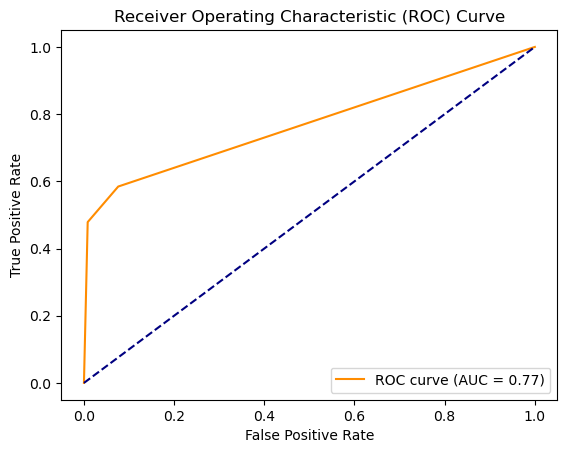

In [5]:

y_prob = knn.predict_proba(X_test)[:, 1]  # predicted probabilities of positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


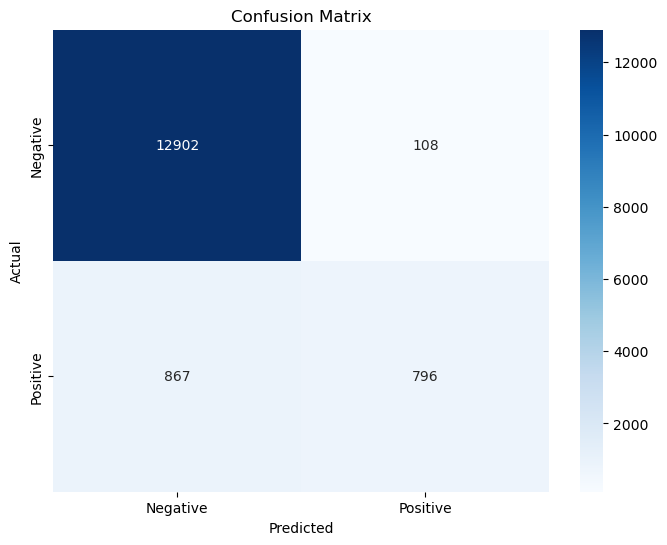

In [6]:
# Generate the confusion matrix
matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [7]:
X = ENMO_vector.reshape(-1,1)  
y = actiware_class_vector.astype(int)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# 1. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Choosing the Right 'k' & 3. Weighted k-NN
params = {
    'n_neighbors': list(range(1, 31)), # Checking values of k from 1 to 30
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()
clf = GridSearchCV(knn, params, cv=5)
clf.fit(X_train_scaled, y_train)

# Predictions
y_pred = clf.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9635
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     13505
           1       0.87      0.64      0.74      1168

    accuracy                           0.96     14673
   macro avg       0.92      0.81      0.86     14673
weighted avg       0.96      0.96      0.96     14673

[[13396   109]
 [  426   742]]


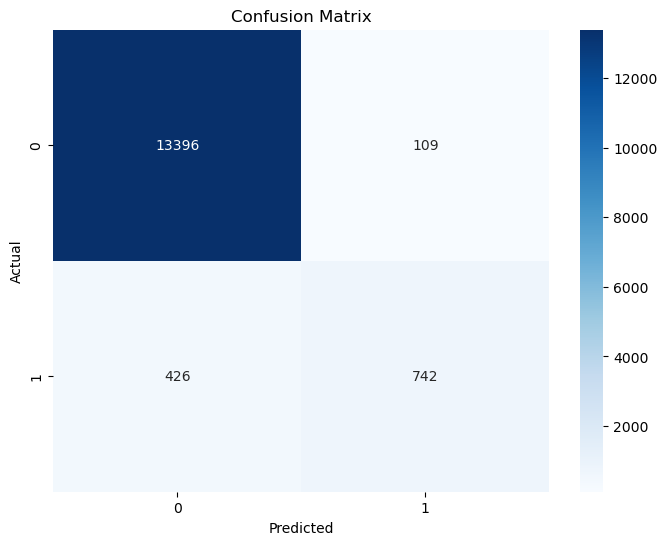

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 25, 'weights': 'uniform'}


In [8]:
# Confusion Matrix Visualization
matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Display best parameters
print(f"Best Parameters: {clf.best_params_}")

In [9]:
assert len(actiware_class_vector) == len(ENMO_vector), "Input and output vectors must have the same length!"

X = ENMO_vector.reshape(-1, 1)
y = actiware_class_vector.astype(int)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning using GridSearchCV
params = {
    'n_neighbors': list(range(1, 21)),  # Checking values of k from 1 to 20
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()
clf = GridSearchCV(knn, params, cv=50)
clf.fit(X_train_scaled, y_train)

# Predicting using the best model
y_pred = clf.predict(X_test_scaled)
y_score = clf.predict_proba(X_test_scaled)[:, 1]  # probabilities for the positive class

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9404
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     13010
           1       0.87      0.56      0.68      1663

    accuracy                           0.94     14673
   macro avg       0.91      0.77      0.82     14673
weighted avg       0.94      0.94      0.93     14673

[[12870   140]
 [  735   928]]


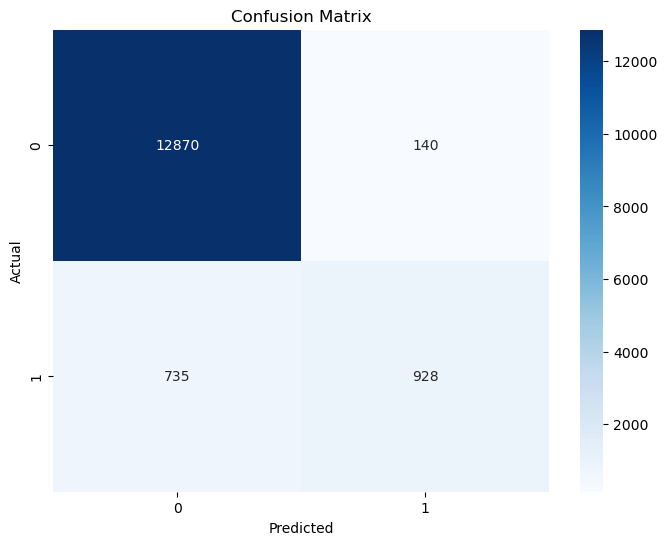

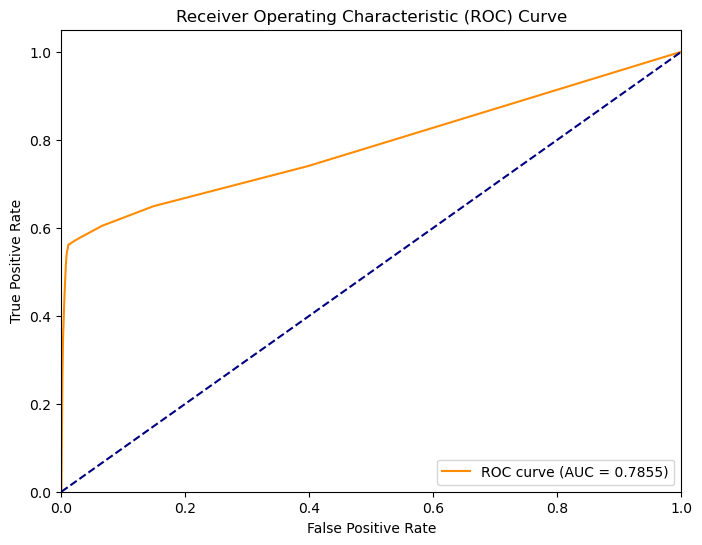

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 19, 'weights': 'uniform'}


In [10]:
# Plotting confusion matrix
matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Plotting ROC curve and computing AUC
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"Best Parameters: {clf.best_params_}")


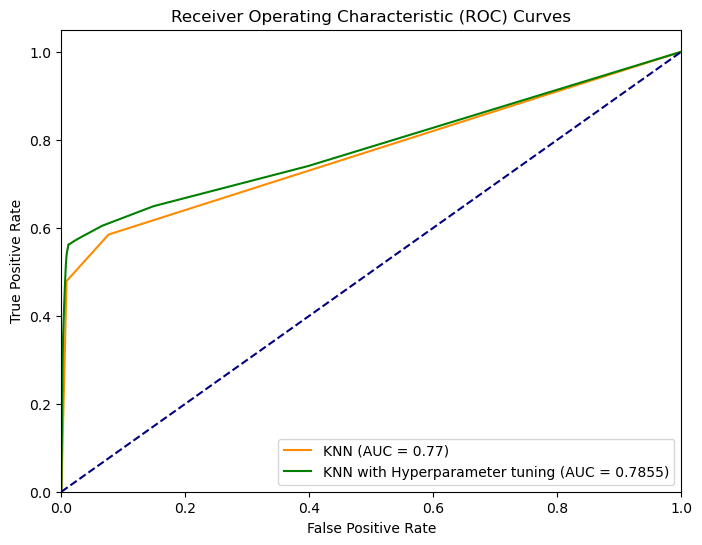

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 19, 'weights': 'uniform'}


In [11]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)  # Fit the model to the training data

y_prob = knn.predict_proba(X_test)[:, 1] 


# ROC curve for the first model (using knn.predict_proba)
y_prob = knn.predict_proba(X_test)[:, 1]  # predicted probabilities of positive class
fpr1, tpr1, _ = roc_curve(y_test, y_prob)
roc_auc1 = auc(fpr1, tpr1)

# Assuming y_score is already defined as predicted probabilities/scores of positive class from another model
fpr2, tpr2, _ = roc_curve(y_test, y_score)
roc_auc2 = auc(fpr2, tpr2)

# Plot both ROC curves on the same graph
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, color='darkorange', label=f'KNN (AUC = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, color='green', label=f'KNN with Hyperparameter tuning (AUC = {roc_auc2:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

# Print the best parameters
print(f"Best Parameters: {clf.best_params_}")


# Random Forest - Rohit

In [ ]:
# Directory containing all CSV files
directory_path = '../Final Assignment/raw_data/'

# List all files in the directory
all_files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

# Initialize an empty list to hold dataframes
dfs = []

# Loop through each file, read the CSV, and append to the list
for file in all_files:
    file_loaded = False
    
    # List of encodings to try
    encodings = ['utf-8', 'latin1', 'ISO-8859-1', 'cp1252']
    
    for encoding in encodings:
        try:
            df = pd.read_csv(os.path.join(directory_path, file), encoding=encoding)
            dfs.append(df)
            file_loaded = True
            break
        except:
            pass
    
    if not file_loaded:
        print(f"Failed to load {file}. It might have a different encoding or contains other issues.")

# Concatenate all dataframes together
merged_data = pd.concat(dfs, ignore_index=True)
merged_data = merged_data.drop(['Unnamed: 2','Unnamed: 0','¸\\'], axis = 1)

merged_data_cleaned = merged_data.dropna(subset=['Actiware classification', 'Actiwatch activity counts', 'Apple Watch ENMO', 'timestamp'])

# Splitting data into training and testing sets (80% train, 20% test)
X = merged_data_cleaned[['Apple Watch ENMO']]
y = merged_data_cleaned['Actiware classification']


Failed to load ._p12_n01_ready.csv. It might have a different encoding or contains other issues.


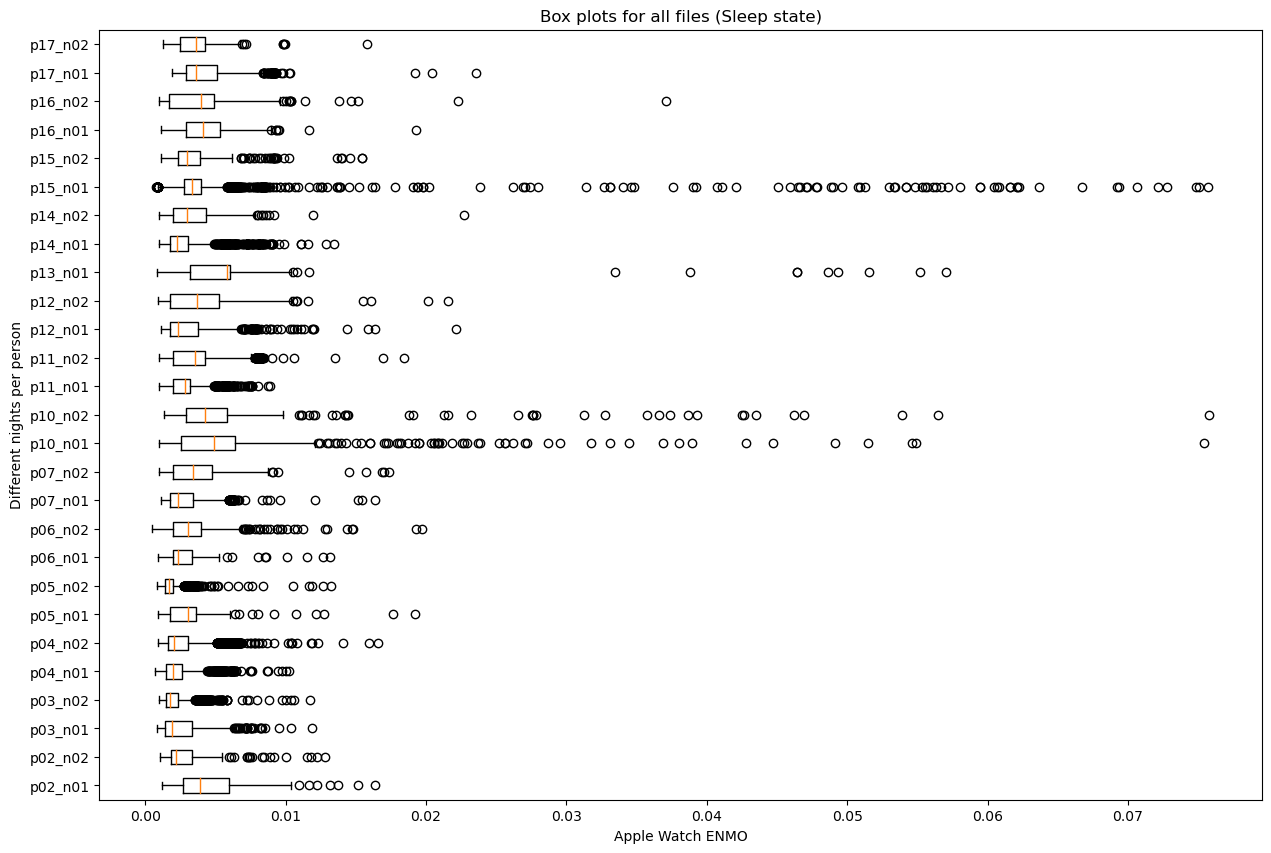

In [13]:
# Create a combined box plot
plt.figure(figsize=(15, 10))
plt.boxplot(data_to_plot, vert=False)
labels = [label.replace("_ready.csv", "") for label in labels]
plt.yticks(range(1, len(labels) + 1), labels)
plt.xlabel("Apple Watch ENMO")
plt.ylabel("Different nights per person")
plt.title("Box plots for all files (Sleep state)")
plt.show()


In [14]:
final_merged = merged_data
final_merged['timestamp'] = pd.to_datetime(final_merged['timestamp'], dayfirst=True)

unique_day_month = final_merged['timestamp'].dt.strftime('%d-%B').unique()

unique_day_month

array([nan, '01-January', '02-January', '03-January', '04-January',
       '05-January', '06-January', '07-January', '08-January',
       '09-January', '10-January', '11-January', '12-January',
       '13-January', '14-January', '15-January', '16-January',
       '17-January', '18-January', '19-January', '20-January',
       '21-January', '22-January', '23-January', '24-January',
       '25-January', '26-January', '27-January', '28-January'],
      dtype=object)

In [15]:
# drop 'Actiwatch activity counts' based on dimitri remarks
january_data = final_merged.drop(columns=['Actiwatch activity counts'])


# Since 'Actiware classification' is our ground truth, we drop rows where this column has missing values
january_data = january_data.dropna(subset=['Actiware classification'])

# replace missing values with the median, so it wont affect by extreme values or outliers in the data
january_data['Apple Watch ENMO'].fillna(january_data['Apple Watch ENMO'].median(), inplace=True)

In [16]:
from sklearn.model_selection import train_test_split
# Split dataset
X = january_data[['Apple Watch ENMO']]
y = january_data['Actiware classification']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

X_train.shape, X_test.shape

((34243, 1), (14676, 1))

In [17]:
#Addition steps
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights = {0: class_weights[0], 1: class_weights[1]}
weights

{0: 0.5439195628693055, 1: 6.1922242314647375}

### Class 1

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

clf_rf = RandomForestClassifier(n_estimators=100, class_weight=weights, random_state=43)

clf_rf.fit(X_train, y_train)
y_pred = clf_rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9237530662305805
Precision: 0.5046583850931677
Recall: 0.5747126436781609
F1 Score: 0.5374121537825548

Confusion Matrix:
 [[12907   638]
 [  481   650]]


### Class 0

Accuracy: 0.9237530662305805
Precision for Class 0: 0.9640723035554227
Recall for Class 0: 0.9528977482465855
F1 Score for Class 0: 0.9584524560947537

Confusion Matrix:
 [[12907   638]
 [  481   650]]


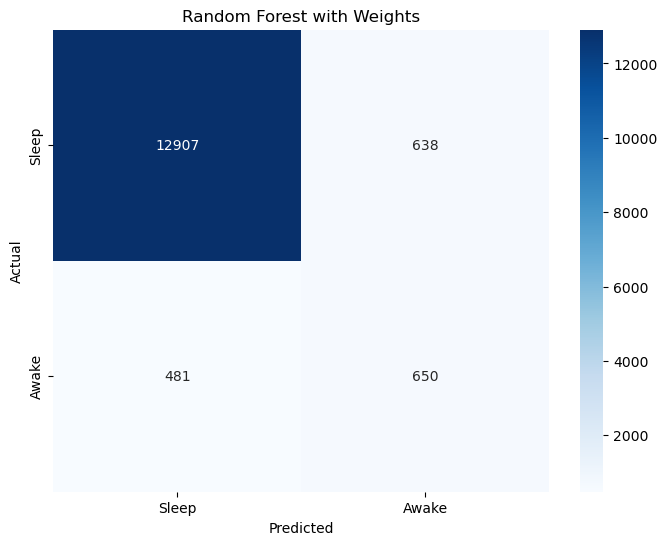

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

clf_rf = RandomForestClassifier(n_estimators=100, class_weight=weights, random_state=43)
clf_rf.fit(X_train, y_train)
y_pred = clf_rf.predict(X_test)

# Compute the metrics, focusing on Class 0 (sleep)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision for Class 0:", precision_score(y_test, y_pred, pos_label=0))
print("Recall for Class 0:", recall_score(y_test, y_pred, pos_label=0))
print("F1 Score for Class 0:", f1_score(y_test, y_pred, pos_label=0))
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# Plot the confusion matrix
labels = ['Sleep', 'Awake']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Random Forest with Weights")
plt.show()

### Gridsearch Hyperparam tuning with class weights

In [20]:
## Re-run to re-do hyperparameter tuning


#from sklearn.model_selection import GridSearchCV
#from sklearn.ensemble import RandomForestClassifier
#
## Set the class weights
#from sklearn.utils.class_weight import compute_class_weight
#class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
#weights = {0: class_weights[0], 1: class_weights[1]}
#
## Define the parameter grid for Random Forest
#param_grid = {
#    'n_estimators': [10, 50, 100, 200],
#    'max_features': ['sqrt'],
#    'max_depth': [10, 20, 30, None],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4],
#    'bootstrap': [True, False],
#    'class_weight': [weights]
#}
#
## Initialize the Random Forest classifier
#rf = RandomForestClassifier(random_state=42)
#
## Instantiate the grid search model
#grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
#                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
#
## Fit the grid search to the data
#grid_search.fit(X_train, y_train)
#
## Print the best hyperparameters
#print("Best hyperparameters:", grid_search.best_params_)
#

In [21]:
# Save the best model from grid search
#joblib.dump(grid_search.best_estimator_, 'best_rf_model_with_weights.pkl')


### Class 1

In [22]:
# Load the saved model
best_rf_model_with_weights = joblib.load('best_rf_model_with_weights.pkl')

# Predict on the test set
y_pred_with_weights = best_rf_model_with_weights.predict(X_test)

# Compute and display the metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred_with_weights))
print("Precision:", precision_score(y_test, y_pred_with_weights))
print("Recall:", recall_score(y_test, y_pred_with_weights))
print("F1 Score:", f1_score(y_test, y_pred_with_weights))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_with_weights))


Accuracy: 0.9352684655219405
Precision: 0.5713159968479118
Recall: 0.6410256410256411
F1 Score: 0.6041666666666667

Confusion Matrix:
 [[13001   544]
 [  406   725]]


### Class 0

Accuracy: 0.9352684655219405
Precision for Class 0: 0.9697173118520176
Recall for Class 0: 0.9598375784422296
F1 Score for Class 0: 0.9647521519738795

Confusion Matrix:
 [[13001   544]
 [  406   725]]


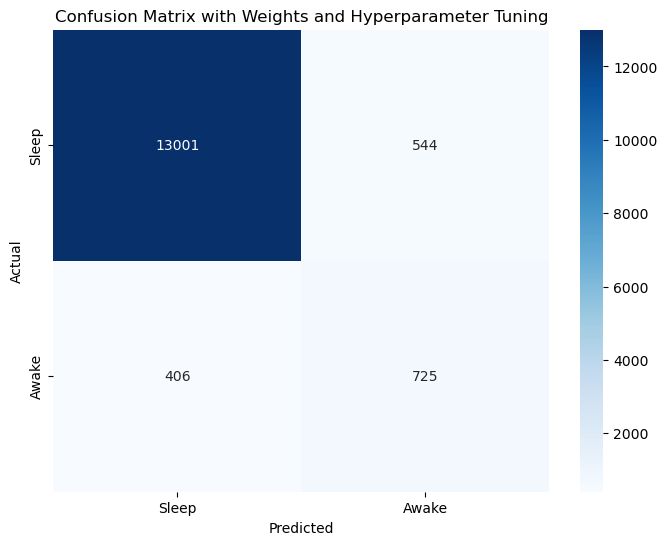

In [23]:
from joblib import load

model_filename = 'best_rf_model_with_weights.pkl'

# Load the saved model
best_rf_model_with_weights = load(model_filename)

# Predict on the test set
y_pred_with_weights = best_rf_model_with_weights.predict(X_test)

# Compute the metrics, focusing on Class 0 (sleep)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred_with_weights))
print("Precision for Class 0:", precision_score(y_test, y_pred_with_weights, pos_label=0))
print("Recall for Class 0:", recall_score(y_test, y_pred_with_weights, pos_label=0))
print("F1 Score for Class 0:", f1_score(y_test, y_pred_with_weights, pos_label=0))
conf_matrix = confusion_matrix(y_test, y_pred_with_weights)
print("\nConfusion Matrix:\n", conf_matrix)

# Plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = ['Sleep', 'Awake']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix with Weights and Hyperparameter Tuning")
plt.show()


## ROC

Without GridSearch and without class weight balancing (Method 1)

In [24]:
y_prob_1_class_1 = clf.predict_proba(X_test)[:, 1]
y_prob_1_class_0 = clf.predict_proba(X_test)[:, 0]


D:\Anaconda\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


With class weighting (Method 2)

In [25]:
y_prob_2_class_1 = clf_rf.predict_proba(X_test)[:, 1]
y_prob_2_class_0 = clf_rf.predict_proba(X_test)[:, 0]


With GridSearch (Method 3)

In [26]:
y_prob_3_class_1 = best_rf_model_with_weights.predict_proba(X_test)[:, 1]
y_prob_3_class_0 = best_rf_model_with_weights.predict_proba(X_test)[:, 0]


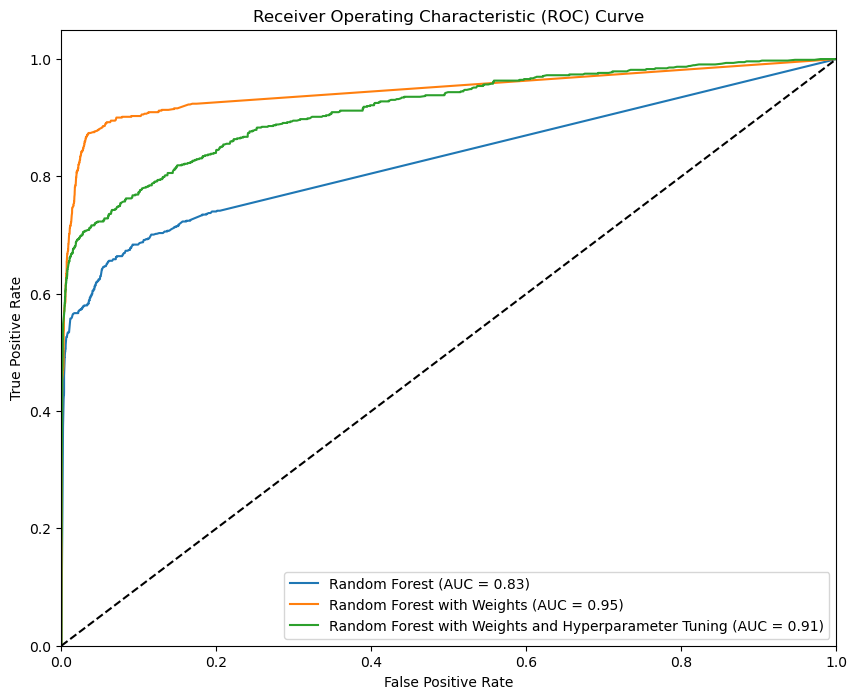

In [81]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Initialize  classifiers
clfs = {
    "Random Forest": clf,  
    "Random Forest with Weights": clf_rf,  # and so on for other classifiers...
    "Random Forest with Weights and Hyperparameter Tuning": best_rf_model_with_weights
}

plt.figure(figsize=(10, 8))

# For each classifier
for name, classifier in clfs.items():
    # Get the probability scores
    probas_ = classifier.predict_proba(X_test)
    
    # Get the ROC curve values
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    
    # Compute Area Under the Curve (AUC)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot the random guess line
plt.plot([0, 1], [0, 1], 'k--')

# Formatting the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.show()


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.show()


D:\Anaconda\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


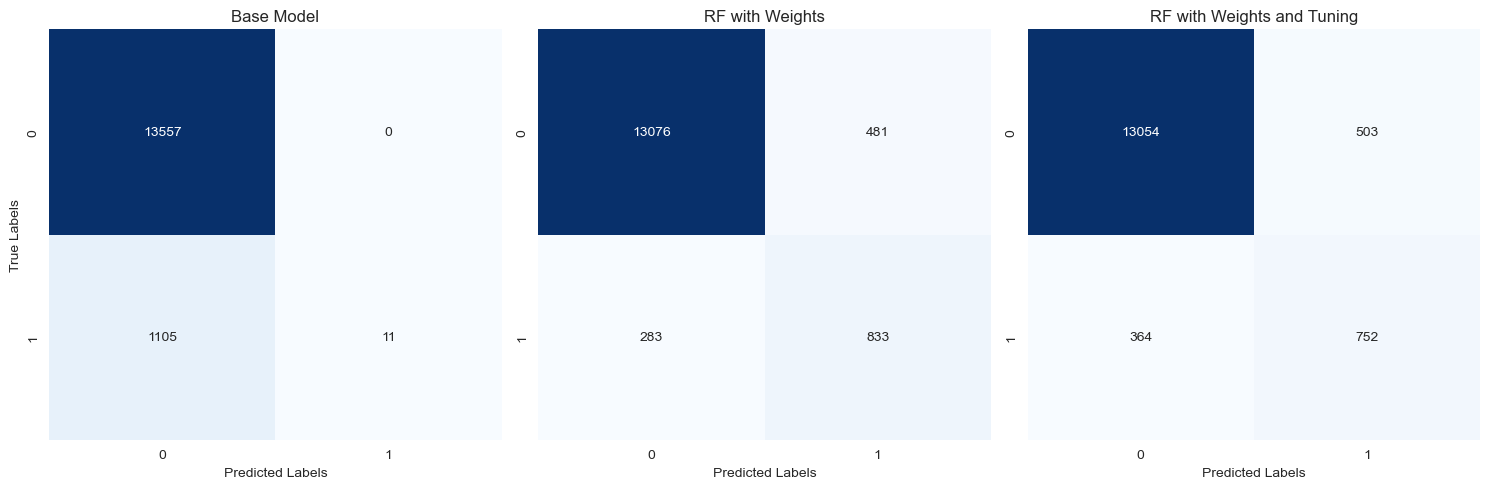

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to plot confusion matrices side by side
def plot_multiple_confusion_matrices(matrices, titles):
    fig, axes = plt.subplots(1, len(matrices), figsize=(15,5))
    for ax, matrix, title in zip(axes, matrices, titles):
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues', cbar=False, ax=ax)
        ax.set_title(title)
        ax.set_xlabel('Predicted Labels')
        if ax is axes[0]:
            ax.set_ylabel('True Labels')
    plt.tight_layout()
    plt.show()

# 1. Base Model
y_pred1 = clf.predict(X_test)
nan_indices = y_test[y_test.isnull()].index
y_test1 = y_test.drop(nan_indices)
y_pred1 = [y_pred1[i] for i in range(len(y_pred1)) if i not in nan_indices]
cm1 = confusion_matrix(y_test1, y_pred1)

# 2. RF with Weights
y_pred2 = clf_rf.predict(X_test)
cm2 = confusion_matrix(y_test, y_pred2)

# 3. RF with Weights and Hyperparameter Tuning
y_pred3 = best_rf_model_with_weights.predict(X_test)
cm3 = confusion_matrix(y_test, y_pred3)

# Plot them all
plot_multiple_confusion_matrices([cm1, cm2, cm3], 
                                 ['Base Model', 'RF with Weights', 'RF with Weights and Tuning'])


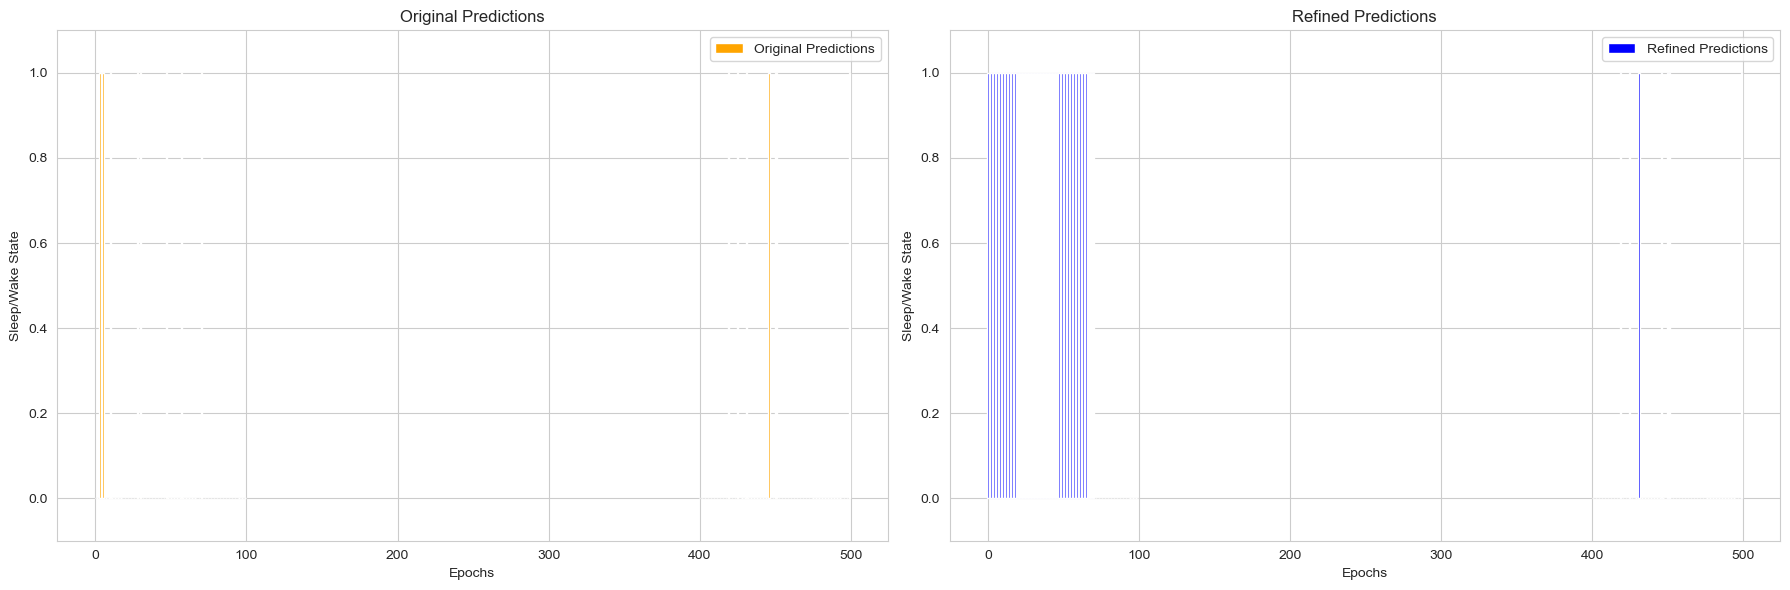

Refined Metrics (RF): (200325, 19770, 91.0175151639065)
Ground Truth Metrics: (203355, 16740, 92.39419341647924)


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_sleep_metrics(predictions):
    """
    Compute the foundational sleep metrics based on the predictions.
    """
    TST = len(predictions[predictions == 0]) * 15  # each epoch is 15 seconds
    TWT = len(predictions[predictions == 1]) * 15  # each epoch is 15 seconds
    SE = (TST / (TST + TWT)) * 100
    return TST, TWT, SE

def refine_predictions_5min(preds):
    """
    Refine the predictions based on the continuity rules for 5 minutes of uninterrupted sleep.
    """
    refined_preds = preds.tolist()
    for i in range(len(refined_preds) - 20):
        if all([epoch == 0 for epoch in refined_preds[i:i+20]]):
            for j in range(i):
                refined_preds[j] = 1
            break
    for i in range(len(refined_preds) - 20, 0, -1):
        if all([epoch == 0 for epoch in refined_preds[i:i+20]]):
            for j in range(i+20, len(refined_preds)):
                refined_preds[j] = 1
            break
    return np.array(refined_preds)

# Predictions from Random Forest model
y_pred_rf = best_rf_model_with_weights.predict(X_test)

# Apply post-processing to the predictions
refined_pred_rf = refine_predictions_5min(y_pred_rf)

# Visualize the changes
original = y_pred_rf[:100].tolist() + y_pred_rf[-100:].tolist()
refined = refined_pred_rf[:100].tolist() + refined_pred_rf[-100:].tolist()

x = list(range(100)) + list(range(400, 500))  # epochs
y1_original = original
y2_refined = refined

plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.bar(x, y1_original, color='orange', label='Original Predictions')
plt.ylim(-0.1, 1.1)
plt.xlabel('Epochs')
plt.ylabel('Sleep/Wake State')
plt.title('Original Predictions')
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(x, y2_refined, color='blue', label='Refined Predictions')
plt.ylim(-0.1, 1.1)
plt.xlabel('Epochs')
plt.ylabel('Sleep/Wake State')
plt.title('Refined Predictions')
plt.legend()

plt.tight_layout()
plt.show()

# Compute metrics for the refined predictions
refined_TST, refined_TWT, refined_SE = compute_sleep_metrics(refined_pred_rf)

# Compute metrics for the ground truth
ground_truth_TST, ground_truth_TWT, ground_truth_SE = compute_sleep_metrics(y_test.values)

refined_metrics_rf = (refined_TST, refined_TWT, refined_SE)
ground_truth_metrics = (ground_truth_TST, ground_truth_TWT, ground_truth_SE)

print("Refined Metrics (RF):", refined_metrics_rf)
print("Ground Truth Metrics:", ground_truth_metrics)


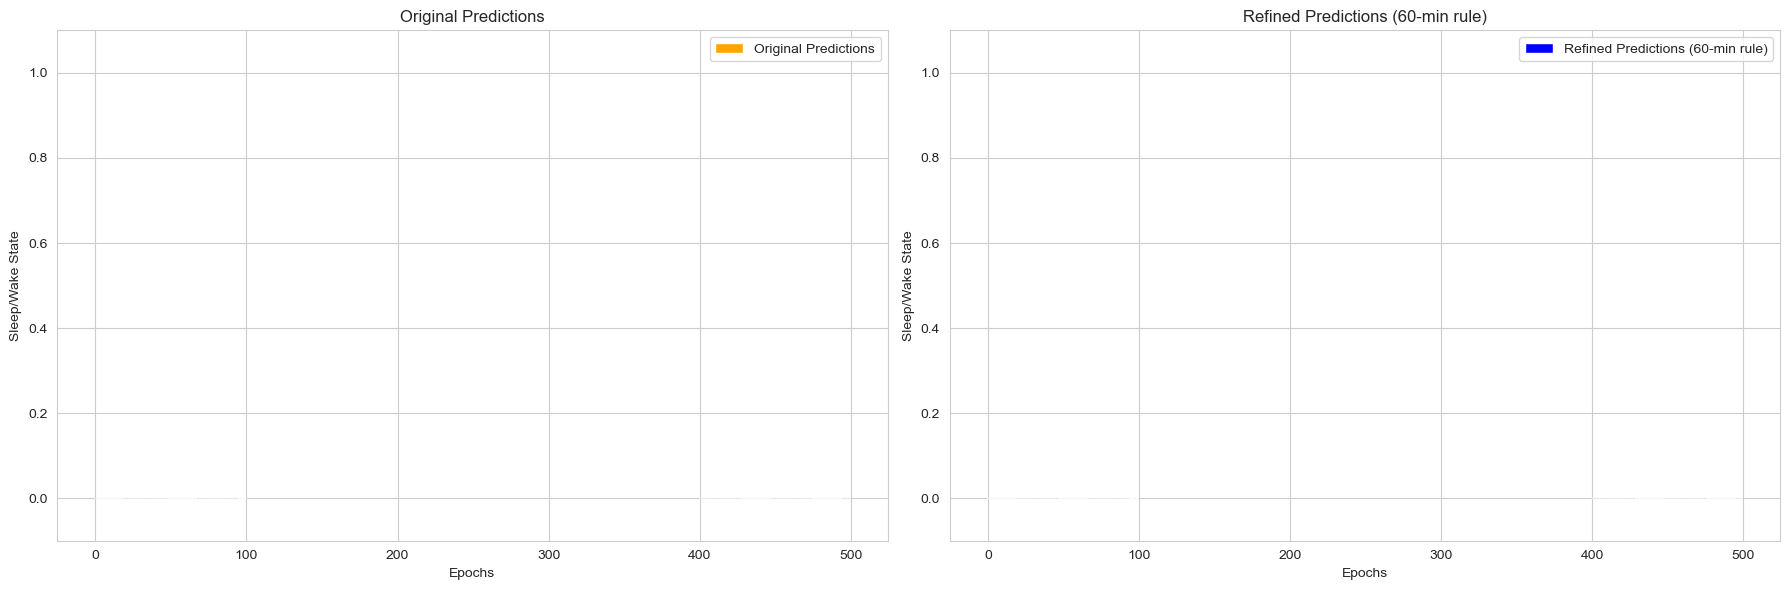

(219930, 165, 99.92503237238465)

In [64]:
def refine_predictions_60min(preds):
    """
    Refine the predictions based on the continuity rules for 60 minutes of uninterrupted sleep.
    """
    refined_preds = preds.tolist()

    # First 60 minutes of uninterrupted sleep
    for i in range(len(refined_preds) - 240):  # 240 epochs = 60 minutes
        if all([epoch == 0 for epoch in refined_preds[i:i+240]]):
            # Set all epochs before this to wake
            for j in range(i):
                refined_preds[j] = 1
            break

    # Last 60 minutes of uninterrupted sleep
    for i in range(len(refined_preds) - 240, 0, -1):
        if all([epoch == 0 for epoch in refined_preds[i:i+240]]):
            # Set all epochs after this to wake
            for j in range(i+240, len(refined_preds)):
                refined_preds[j] = 1
            break

    return np.array(refined_preds)
X_test = X_test.to_numpy()

# Predict using Random Forest
y_pred_rf = clf.predict(X_test)

# Apply post-processing to the predictions from Random Forest with Weights and Hyperparameter Tuning using the 60-minute rule
refined_pred_rf_60min = refine_predictions_60min(y_pred_rf)

# Check the first and last 100 epochs to see the changes
original_rf_60min = y_pred_rf[:100].tolist() + y_pred_rf[-100:].tolist()
refined_rf_60min = refined_pred_rf_60min[:100].tolist() + refined_pred_rf_60min[-100:].tolist()

# Plotting
x_rf_60min = list(range(100)) + list(range(400, 500))  # epochs
y1_original_rf_60min = original_rf_60min
y2_refined_rf_60min = refined_rf_60min

plt.figure(figsize=(18, 6))

# Original predictions
plt.subplot(1, 2, 1)
plt.bar(x_rf_60min, y1_original_rf_60min, color='orange', label='Original Predictions')
plt.ylim(-0.1, 1.1)
plt.xlabel('Epochs')
plt.ylabel('Sleep/Wake State')
plt.title('Original Predictions')
plt.legend()

# Refined predictions using 60-minute rule
plt.subplot(1, 2, 2)
plt.bar(x_rf_60min, y2_refined_rf_60min, color='blue', label='Refined Predictions (60-min rule)')
plt.ylim(-0.1, 1.1)
plt.xlabel('Epochs')
plt.ylabel('Sleep/Wake State')
plt.title('Refined Predictions (60-min rule)')
plt.legend()

plt.tight_layout()
plt.show()

# Compute metrics for the refined predictions using 60-minute rule
refined_TST_rf_60min, refined_TWT_rf_60min, refined_SE_rf_60min = compute_sleep_metrics(refined_pred_rf_60min)

refined_metrics_rf_60min = (refined_TST_rf_60min, refined_TWT_rf_60min, refined_SE_rf_60min)
refined_metrics_rf_60min


# Support Vector Machine(SVM) - Chee Han Wong (Mark)

In [44]:
# Extract unique day-month combinations from the 'timestamp' column of the filtered data
unique_day_month = final_merged['timestamp'].dt.strftime('%d-%B').unique()

# Return the unique day-month combinations in the filtered data
unique_day_month


array(['01-January', '02-January', '03-January', '04-January',
       '05-January', '06-January', '07-January', '08-January',
       '09-January', '10-January', '11-January', '12-January',
       '13-January', '14-January', '15-January', '16-January',
       '17-January', '18-January', '19-January', '20-January',
       '21-January', '22-January', '23-January', '24-January',
       '25-January', '26-January', '27-January', '28-January'],
      dtype=object)

In [45]:
summary_january_data = final_merged.describe(include='all')

# missing values count
missing_values_january_data = final_merged.isnull().sum()

summary_january_data, missing_values_january_data


(                           timestamp  Actiwatch activity counts  \
 count                          49312               49100.000000   
 mean   2000-01-14 12:06:48.548020864                   4.110468   
 min              2000-01-01 01:17:00                   0.000000   
 25%       2000-01-07 03:48:56.250000                   0.000000   
 50%       2000-01-15 02:48:52.500000                   0.000000   
 75%       2000-01-21 01:35:48.750000                   0.000000   
 max              2000-01-28 08:57:45                 880.000000   
 std                              NaN                  24.561319   
 
        Actiware classification  Apple Watch ENMO  
 count             48919.000000      49278.000000  
 mean                  0.079642          0.006621  
 min                   0.000000          0.000505  
 25%                   0.000000          0.001897  
 50%                   0.000000          0.003029  
 75%                   0.000000          0.004746  
 max                  

In [46]:
# Drop Unnecessary Columns
january_data = final_merged.drop(columns=['Actiwatch activity counts'])

# Handling Missing Values:
# Since 'Actiware classification' is our ground truth, we'll drop rows where this column has missing values
# For 'Apple Watch ENMO', we'll replace missing values with the median of the column
january_data = january_data.dropna(subset=['Actiware classification'])
january_data['Apple Watch ENMO'].fillna(january_data['Apple Watch ENMO'].median(), inplace=True)

january_data.head()


,timestamp,Actiware classification,Apple Watch ENMO
15,2000-01-01 01:20:45,1.0,0.007234
16,2000-01-01 01:21:00,1.0,0.030109
17,2000-01-01 01:21:15,1.0,0.008785
18,2000-01-01 01:21:30,1.0,0.007893
19,2000-01-01 01:21:45,1.0,0.007761


In [47]:
print(january_data.isnull().sum())

timestamp                  0
Actiware classification    0
Apple Watch ENMO           0
dtype: int64


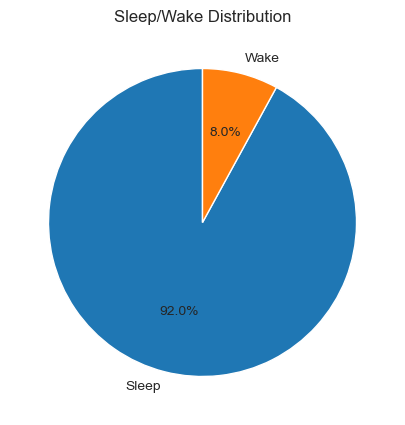

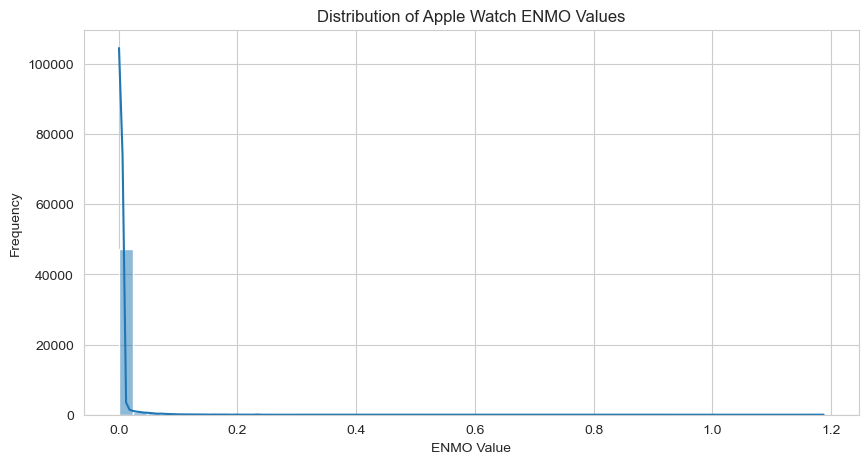

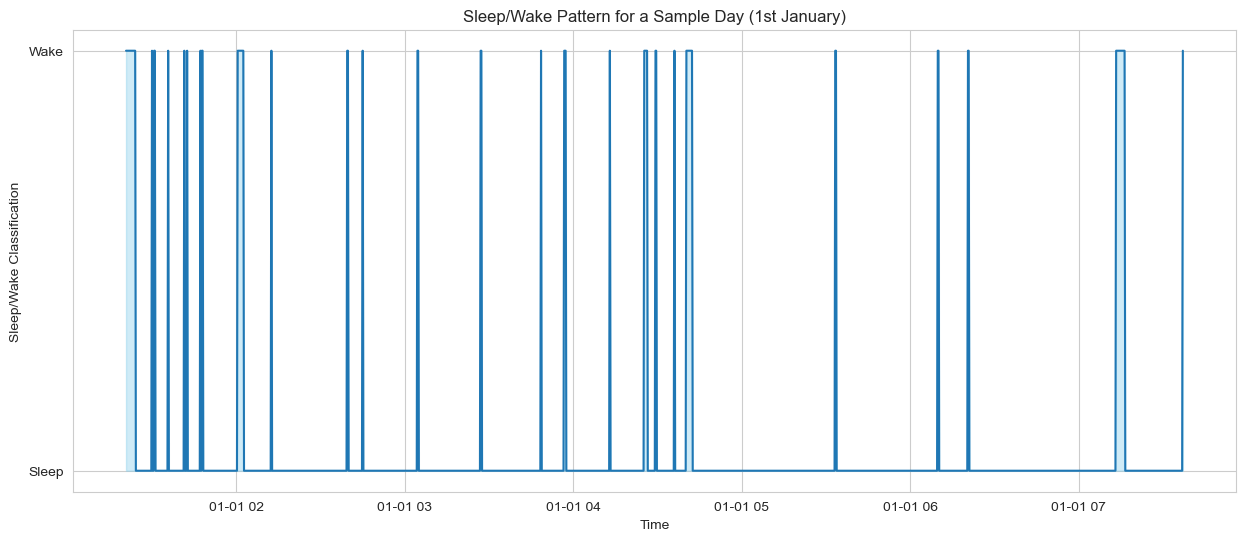

In [48]:
sns.set_style("whitegrid")

# Sleep/Wake Distribution:
plt.figure(figsize=(10, 5))
january_data['Actiware classification'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, labels=['Sleep', 'Wake'])
plt.title('Sleep/Wake Distribution')
plt.ylabel('')  # Remove the default ylabel
plt.show()

# Visualizing ENMO values:
plt.figure(figsize=(10, 5))
sns.histplot(january_data['Apple Watch ENMO'], bins=50, kde=True)
plt.title('Distribution of Apple Watch ENMO Values')
plt.xlabel('ENMO Value')
plt.ylabel('Frequency')
plt.show()

# Sleep/Wake patterns over time (sample day):
sample_day_data = january_data[january_data['timestamp'].dt.day == 1]
plt.figure(figsize=(15, 6))
plt.plot(sample_day_data['timestamp'], sample_day_data['Actiware classification'])
plt.fill_between(sample_day_data['timestamp'], sample_day_data['Actiware classification'], color='skyblue', alpha=0.4)
plt.title('Sleep/Wake Pattern for a Sample Day (1st January)')
plt.xlabel('Time')
plt.ylabel('Sleep/Wake Classification')
plt.yticks([0, 1], ['Sleep', 'Wake'])
plt.show()


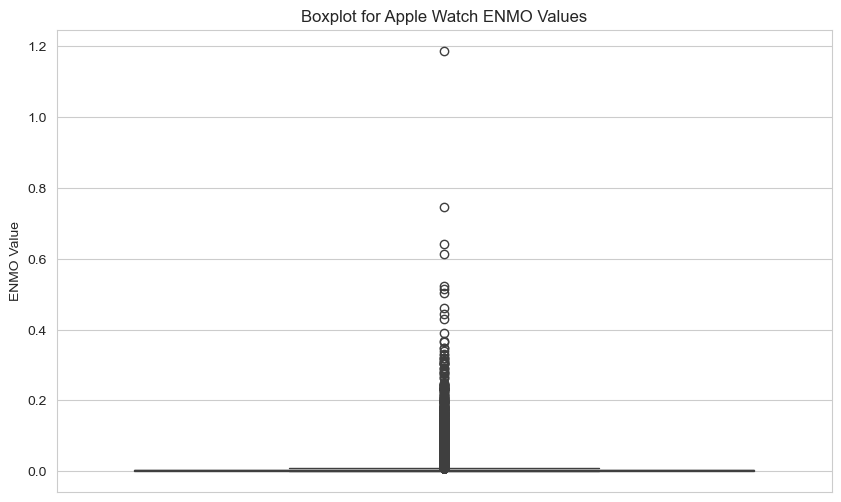

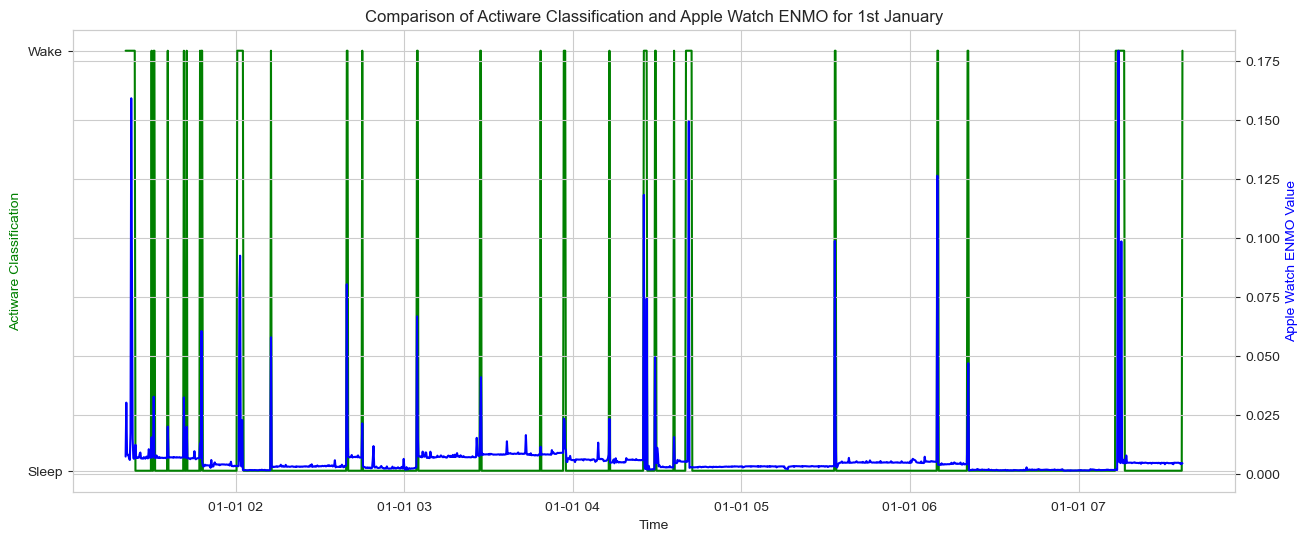

C:\Users\markw\AppData\Local\Temp\ipykernel_20648\2098070340.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(january_data[january_data['Actiware classification'] == 0]['Apple Watch ENMO'], shade=True, label='Sleep')
C:\Users\markw\AppData\Local\Temp\ipykernel_20648\2098070340.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(january_data[january_data['Actiware classification'] == 1]['Apple Watch ENMO'], shade=True, label='Wake')


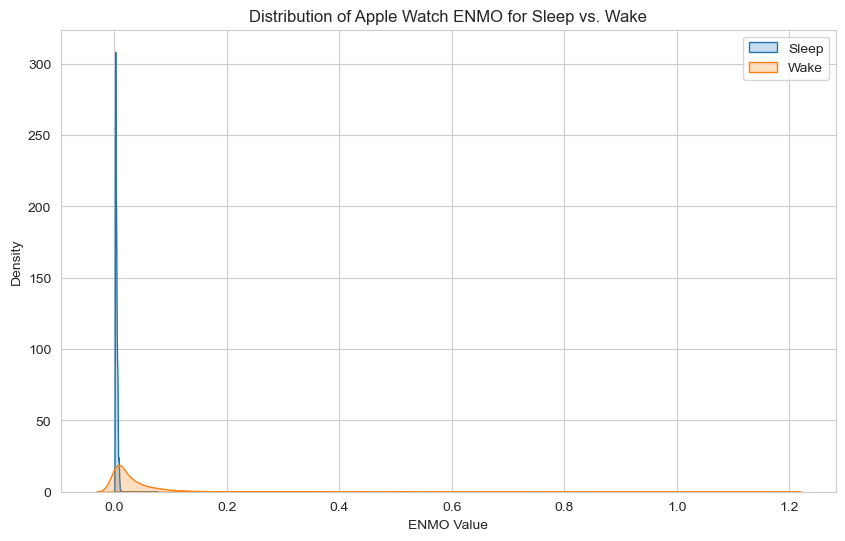

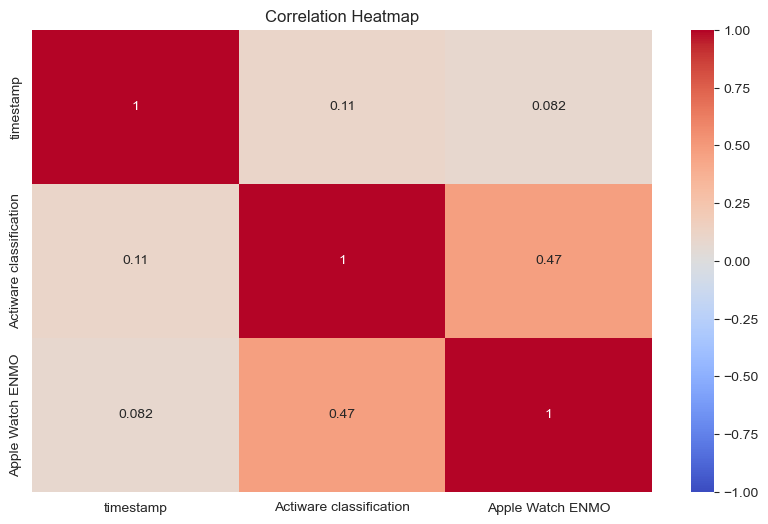

In [49]:
# Boxplot for Apple Watch ENMO
plt.figure(figsize=(10, 6))
sns.boxplot(y=january_data['Apple Watch ENMO'])
plt.title('Boxplot for Apple Watch ENMO Values')
plt.ylabel('ENMO Value')
plt.show()

# Time Series Comparison of Actiware Classification and Apple Watch ENMO
# For clarity, plotting a sample day (1st January)
sample_day_data = january_data[january_data['timestamp'].dt.day == 1]
fig, ax1 = plt.subplots(figsize=(15, 6))


ax2 = ax1.twinx()

ax1.plot(sample_day_data['timestamp'], sample_day_data['Actiware classification'], 'g-')
ax1.set_ylabel('Actiware Classification', color='g')
ax1.set_xlabel('Time')
ax1.set_yticks([0, 1])
ax1.set_yticklabels(['Sleep', 'Wake'])

ax2.plot(sample_day_data['timestamp'], sample_day_data['Apple Watch ENMO'], 'b-')
ax2.set_ylabel('Apple Watch ENMO Value', color='b')

plt.title('Comparison of Actiware Classification and Apple Watch ENMO for 1st January')
plt.show()

# Distribution of Apple Watch ENMO for Sleep vs. Wake
plt.figure(figsize=(10, 6))
sns.kdeplot(january_data[january_data['Actiware classification'] == 0]['Apple Watch ENMO'], shade=True, label='Sleep')
sns.kdeplot(january_data[january_data['Actiware classification'] == 1]['Apple Watch ENMO'], shade=True, label='Wake')
plt.title('Distribution of Apple Watch ENMO for Sleep vs. Wake')
plt.xlabel('ENMO Value')
plt.ylabel('Density')
plt.legend()
plt.show()

# Correlation Heatmap
corr_matrix = january_data.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


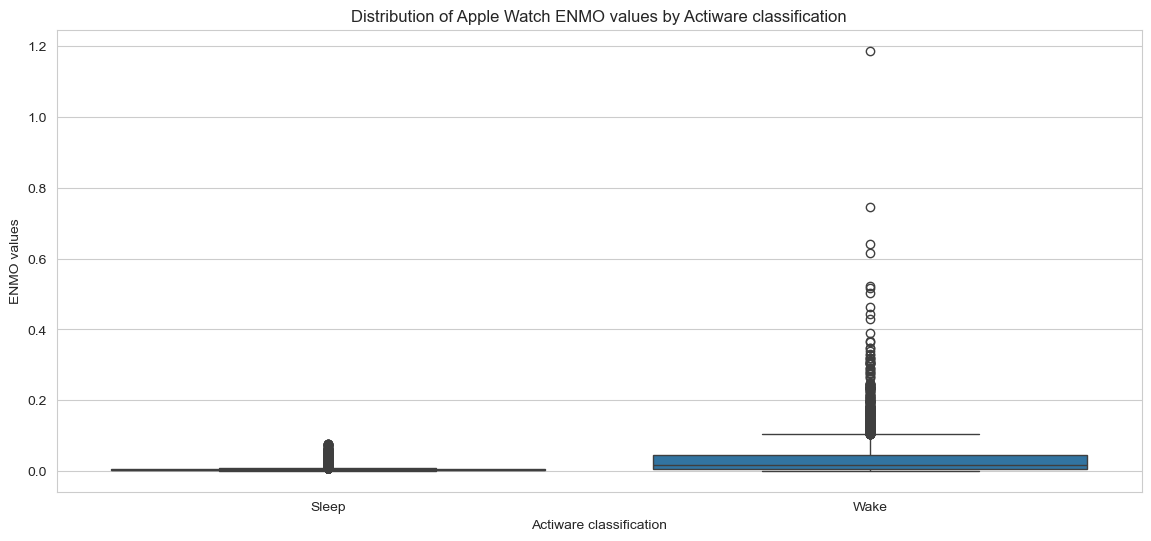

In [50]:
# Distribution of Apple Watch ENMO values based on Actiware classification
plt.figure(figsize=(14, 6))
sns.boxplot(x=january_data['Actiware classification'], y=january_data['Apple Watch ENMO'])
plt.title('Distribution of Apple Watch ENMO values by Actiware classification')
plt.xticks([0, 1], ['Sleep', 'Wake'])
plt.ylabel('ENMO values')
plt.show()


In [51]:
# Split dataset
X = january_data[['Apple Watch ENMO']]
y = january_data['Actiware classification']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

X_train.shape, X_test.shape

((34243, 1), (14676, 1))

In [52]:
print(y_test.describe())

count    14676.000000
mean         0.077065
std          0.266703
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Actiware classification, dtype: float64


In [53]:
print(X_train.isnull().sum())
print(X_test.isnull().sum())

print(y_train.isnull().sum()) 
print(y_test.isnull().sum())  

Apple Watch ENMO    0
dtype: int64
Apple Watch ENMO    0
dtype: int64
0
0


In [54]:
# Train an SVM classifier
svm_classifier = SVC(kernel='linear', C=1, random_state=3)
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)
# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=1)

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")
print("\nClassification Report:\n", report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)



Accuracy: 0.94
ROC AUC Score: 0.63

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     13545
         1.0       0.93      0.25      0.40      1131

    accuracy                           0.94     14676
   macro avg       0.94      0.63      0.68     14676
weighted avg       0.94      0.94      0.93     14676

[[13524    21]
 [  843   288]]


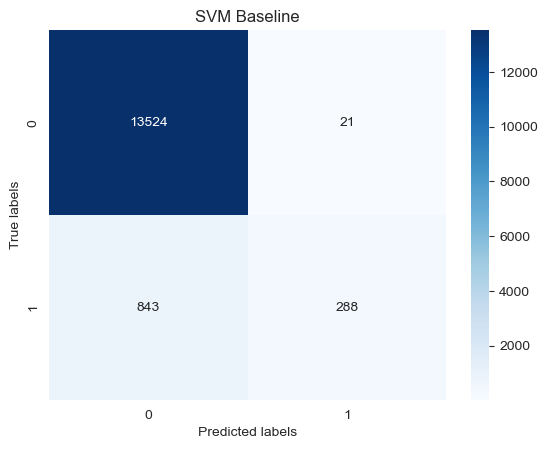

In [55]:
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('SVM Baseline')
plt.show()

In [56]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights = {0: class_weights[0], 1: class_weights[1]}

weights

{0: 0.5439195628693055, 1: 6.1922242314647375}

In [19]:

# Assign class weights to handle imbalance. 
svm_classifier_weights = SVC(kernel='linear', C=1, class_weight=weights, random_state=3)
svm_classifier_weights.fit(X_train, y_train)
y_pred_weights = svm_classifier_weights.predict(X_test)

# Evaluate model
accuracy_weights = accuracy_score(y_test, y_pred_weights)
roc_auc_weights = roc_auc_score(y_test, y_pred_weights)
report_weights = classification_report(y_test, y_pred_weights)

print(f"Accuracy: {accuracy_weights:.2f}")
print(f"ROC AUC Score: {roc_auc_weights:.2f}")
print("\nClassification Report:\n", report_weights)


# Confusion Matrix
conf_matrix_weights = confusion_matrix(y_test, y_pred_weights)
print(conf_matrix_weights)



Accuracy: 0.96
ROC AUC Score: 0.74

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     13545
         1.0       0.91      0.48      0.63      1131

    accuracy                           0.96     14676
   macro avg       0.93      0.74      0.80     14676
weighted avg       0.95      0.96      0.95     14676

[[13489    56]
 [  586   545]]


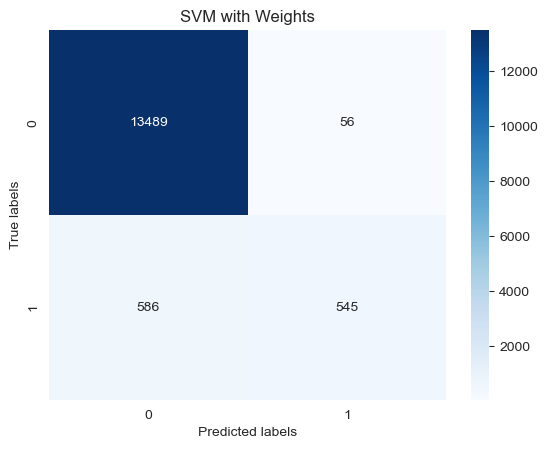

In [20]:
sns.heatmap(conf_matrix_weights, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('SVM with Weights')
plt.show()

In [21]:
## RERUN FOR VERIFICATION ##

# # Defin hyperparameters grid
# param_grid = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'rbf', ''],
#     'gamma': ['scale', 'auto']
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(
#     SVC(random_state=3),
#     param_grid,
#     cv=5,
#     scoring='accuracy',
#     verbose=4,
#     n_jobs=-1  
# )

# # Run GridSearchCV
# grid_search.fit(X_train, y_train)

# print(f"Best Parameters: {grid_search.best_params_}")
# print(f"Best Score: {grid_search.best_score_:.4f}")

In [35]:
# # Save best hyperparameters
# with open('best_params.pkl', 'wb') as file:
#     pickle.dump(grid_search.best_params_, file)

# # load function
# with open('best_params.pkl', 'rb') as file:
#     loaded_best_params = pickle.load(file)

# print("Loaded Parameters:", loaded_best_params)

Accuracy: 0.95
ROC AUC Score: 0.79

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.98      0.97     13545
         1.0       0.72      0.61      0.66      1131

    accuracy                           0.95     14676
   macro avg       0.84      0.79      0.82     14676
weighted avg       0.95      0.95      0.95     14676

[[13279   266]
 [  446   685]]


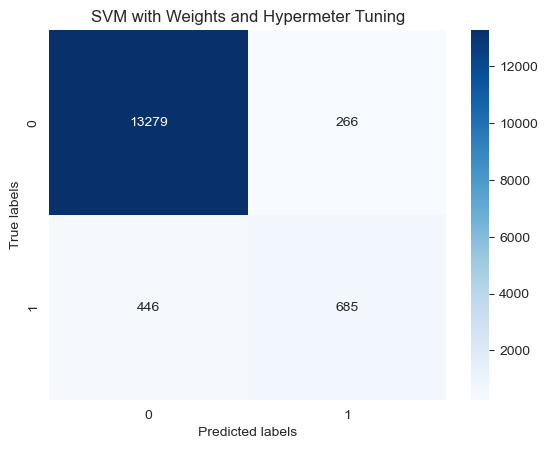

In [23]:
# Retrain the tuned model 
svm_classifier_htweights = SVC(C=10, gamma='scale', kernel='rbf', class_weight=weights, random_state=3)
svm_classifier_htweights.fit(X_train, y_train)
y_pred_htweights = svm_classifier_htweights.predict(X_test)

accuracy_htweights = accuracy_score(y_test, y_pred_htweights)
roc_auc_htweights = roc_auc_score(y_test, y_pred_htweights)
report_htweights = classification_report(y_test, y_pred_htweights)

print(f"Accuracy: {accuracy_htweights:.2f}")
print(f"ROC AUC Score: {roc_auc_htweights:.2f}")
print("\nClassification Report:\n", report_htweights)

conf_matrix_htweights = confusion_matrix(y_test, y_pred_htweights)
print(conf_matrix_htweights)

sns.heatmap(conf_matrix_htweights, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('SVM with Weights and Hypermeter Tuning')
plt.show()

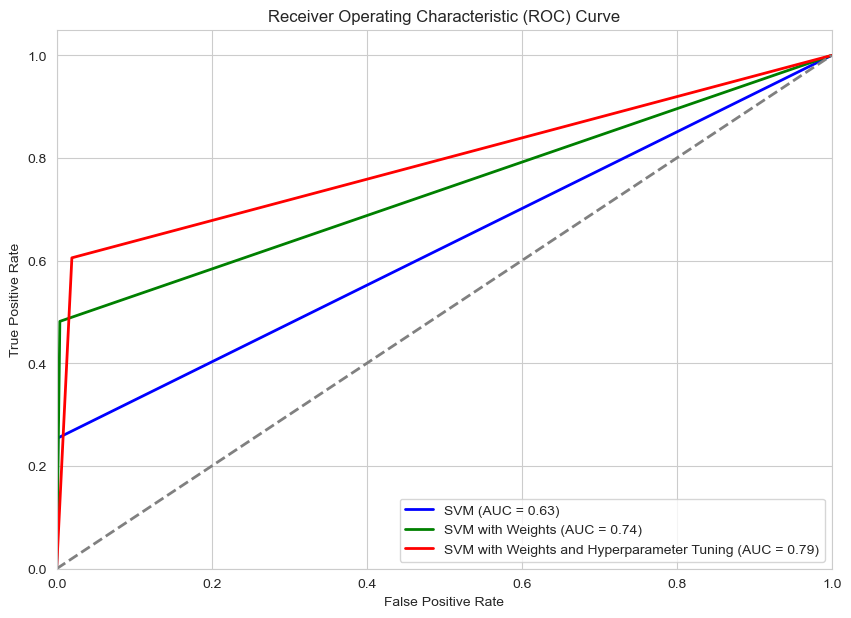

In [57]:
# Get and plot the ROC curve values for the three models
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

fpr_weights, tpr_weights, _ = roc_curve(y_test, y_pred_weights)
roc_auc_weights = auc(fpr_weights, tpr_weights)

fpr_htweights, tpr_htweights, _ = roc_curve(y_test, y_pred_htweights)
roc_auc_htweights = auc(fpr_htweights, tpr_htweights)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'SVM (AUC = {roc_auc:.2f})')
plt.plot(fpr_weights, tpr_weights, color='green', lw=2, label=f'SVM with Weights (AUC = {roc_auc_weights:.2f})')
plt.plot(fpr_htweights, tpr_htweights, color='red', lw=2, label=f'SVM with Weights and Hyperparameter Tuning (AUC = {roc_auc_htweights:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


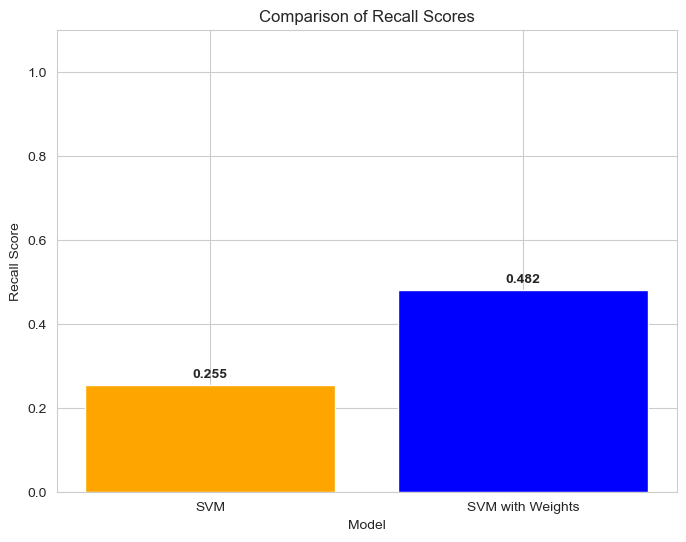

In [58]:
# Calculate recall scores
recall_svm = recall_score(y_test, y_pred)
recall_svm_weights = recall_score(y_test, y_pred_weights)

# Data for the bar plot
models = ['SVM', 'SVM with Weights']
recall_scores = [recall_svm, recall_svm_weights]

plt.figure(figsize=(8, 6))
plt.bar(models, recall_scores, color=['orange', 'blue'])
plt.xlabel('Model')
plt.ylabel('Recall Score')
plt.title('Comparison of Recall Scores')
plt.ylim(0, 1.1)  # adjust this for better visualization if needed
for i, v in enumerate(recall_scores):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', va='bottom', fontweight='bold')
plt.show()


In [ ]:
def compute_sleep_metrics(predictions):
    """
    Compute the foundational sleep metrics based on the predictions.
    """
    # Total Sleep Time (TST)
    TST = len(predictions[predictions == 0]) * 15  # each epoch is 15 seconds

    # Total Wake Time (TWT)
    TWT = len(predictions[predictions == 1]) * 15  # each epoch is 15 seconds

    # Sleep Efficiency (SE)
    SE = (TST / (TST + TWT)) * 100

    return TST, TWT, SE

In [ ]:
def refine_predictions_5min(preds):
    """
    Refine the predictions based on the continuity rules for 5 minutes of uninterrupted sleep..
    """
    # Convert predictions to a list for easier processing
    refined_preds = preds.tolist()

    # First 5 minutes of uninterrupted sleep
    for i in range(len(refined_preds) - 20):
        if all([epoch == 0 for epoch in refined_preds[i:i+20]]):
            # Set all epochs before this to wake
            for j in range(i):
                refined_preds[j] = 1
            break

    # Last 5 minutes of uninterrupted sleep
    for i in range(len(refined_preds) - 20, 0, -1):
        if all([epoch == 0 for epoch in refined_preds[i:i+20]]):
            # Set all epochs after this to wake
            for j in range(i+20, len(refined_preds)):
                refined_preds[j] = 1
            break

    return np.array(refined_preds)

# Apply post-processing to the predictions from SVM with Weights and Hyperparameter Tuning
refined_pred_htweights = refine_predictions_5min(y_pred_htweights)

# Check the first and last 100 epochs to see the changes
original = y_pred_htweights[:100].tolist() + y_pred_htweights[-100:].tolist()
refined = refined_pred_htweights[:100].tolist() + refined_pred_htweights[-100:].tolist()

original, refined


([0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,

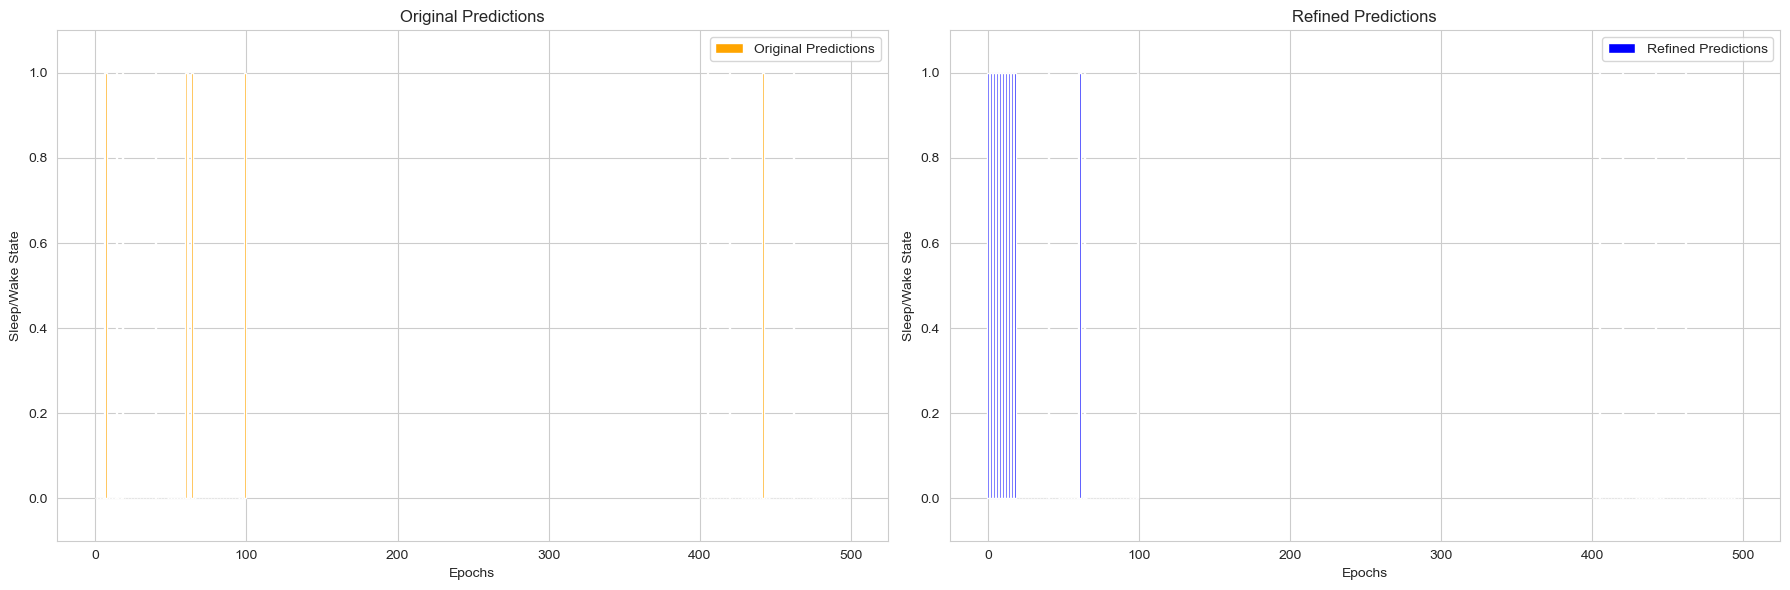

((205650, 14490, 93.41782502044154), (203175, 16965, 92.29354047424366))

In [61]:
x = list(range(100)) + list(range(400, 500))  # epochs
y1_original = original
y2_refined = refined

plt.figure(figsize=(18, 6))

# Original predictions
plt.subplot(1, 2, 1)
plt.bar(x, y1_original, color='orange', label='Original Predictions')
plt.ylim(-0.1, 1.1)
plt.xlabel('Epochs')
plt.ylabel('Sleep/Wake State')
plt.title('Original Predictions')
plt.legend()

# Refined predictions
plt.subplot(1, 2, 2)
plt.bar(x, y2_refined, color='blue', label='Refined Predictions')
plt.ylim(-0.1, 1.1)
plt.xlabel('Epochs')
plt.ylabel('Sleep/Wake State')
plt.title('Refined Predictions')
plt.legend()

plt.tight_layout()
plt.show()


# Compute metrics for the refined predictions
refined_TST, refined_TWT, refined_SE = compute_sleep_metrics(refined_pred_htweights)

# Compute metrics for the ground truth (Actiwatch classifications)
ground_truth_TST, ground_truth_TWT, ground_truth_SE = compute_sleep_metrics(y_test.values)

refined_metrics = (refined_TST, refined_TWT, refined_SE)
ground_truth_metrics = (ground_truth_TST, ground_truth_TWT, ground_truth_SE)

refined_metrics, ground_truth_metrics


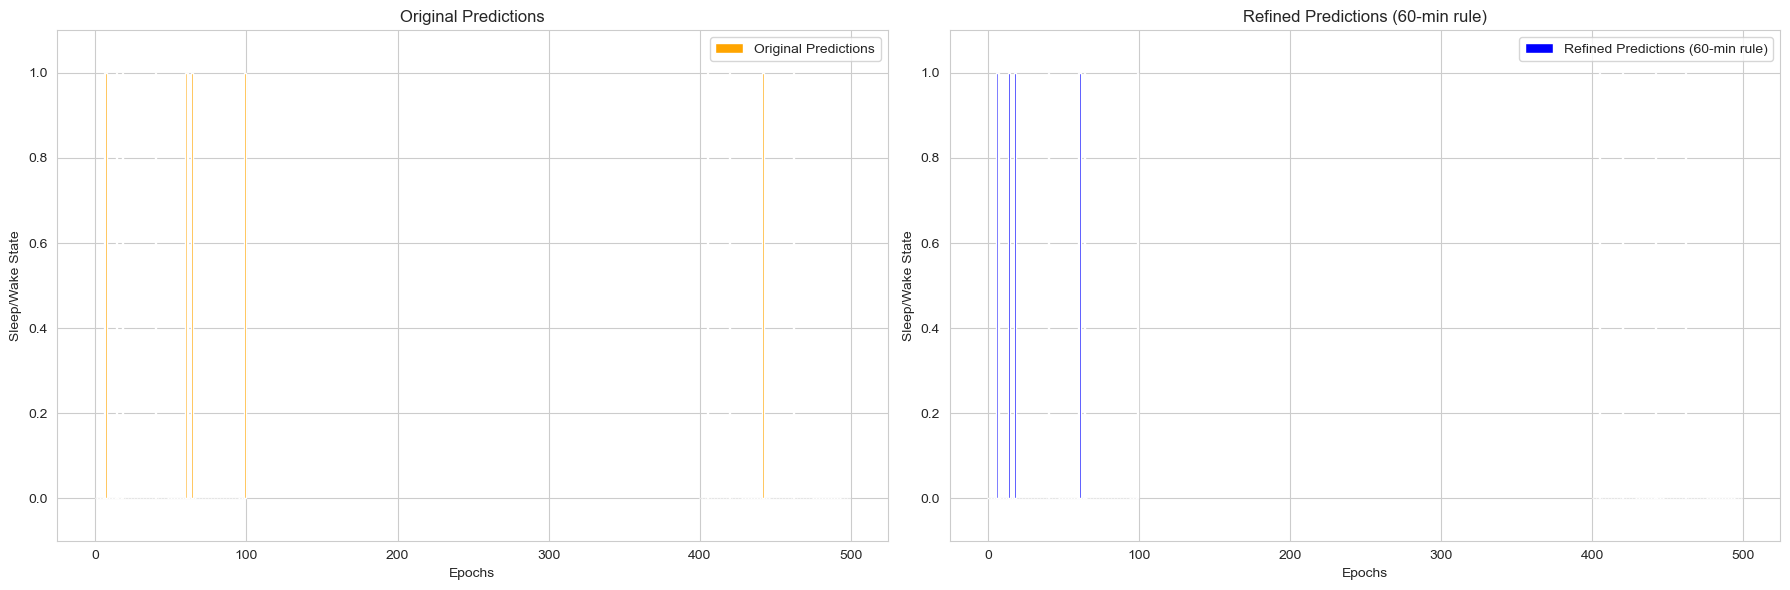

(205875, 14265, 93.52003270645952)

In [63]:
# Apply post-processing to the predictions from SVM with Weights and Hyperparameter Tuning using the 60-minute rule
refined_pred_60min = refine_predictions_60min(y_pred_htweights)

# Check the first and last 100 epochs to see the changes
original_60min = y_pred_htweights[:100].tolist() + y_pred_htweights[-100:].tolist()
refined_60min = refined_pred_60min[:100].tolist() + refined_pred_60min[-100:].tolist()

# pltting
x_60min = list(range(100)) + list(range(400, 500))  # epochs
y1_original_60min = original_60min
y2_refined_60min = refined_60min

plt.figure(figsize=(18, 6))

# Original predictions
plt.subplot(1, 2, 1)
plt.bar(x_60min, y1_original_60min, color='orange', label='Original Predictions')
plt.ylim(-0.1, 1.1)
plt.xlabel('Epochs')
plt.ylabel('Sleep/Wake State')
plt.title('Original Predictions')
plt.legend()

# Refined predictions using 60-minute rule
plt.subplot(1, 2, 2)
plt.bar(x_60min, y2_refined_60min, color='blue', label='Refined Predictions (60-min rule)')
plt.ylim(-0.1, 1.1)
plt.xlabel('Epochs')
plt.ylabel('Sleep/Wake State')
plt.title('Refined Predictions (60-min rule)')
plt.legend()

plt.tight_layout()
plt.show()

# Compute metrics for the refined predictions using 60-minute rule
refined_TST_60min, refined_TWT_60min, refined_SE_60min = compute_sleep_metrics(refined_pred_60min)

refined_metrics_60min = (refined_TST_60min, refined_TWT_60min, refined_SE_60min)
refined_metrics_60min


## End of file